<a href="https://colab.research.google.com/github/Riyachauhan11/Travel-Itinerary-Planner/blob/main/Travel_Itinerary_Planner_MultiAI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Components



1.   **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2.   **PlannerState**: A custom type representing the state of our planning process.
3. **Node** **Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM** **Integration**: Utilizing a language model to generate the final itinerary.







# New Section

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [ ]:
import os
# for creating Planner State
from typing import TypedDict, Annotated, List
# for creating StateGraph
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

Define Agent

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage],"the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define agent Functions

In [ ]:
# human input
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your input: ")
  return {
      **state,
      "city": user_message,
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }

def input_interests(state: PlannerState) -> PlannerState:
  print(f"Please enter your interests for the trip to : {state['city']} (comma-separated): ")
  user_message = input("Your input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }
# AI Response
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city=state['city'],interests = ', '.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state["messages"] + [AIMessage(content=response.content)],
      "itinerary": response.content
  }

Create and compile the Graph


In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input city",input_city)
workflow.add_node("input interests",input_interests)
workflow.add_node("create itinerary",create_itinerary)

workflow.set_entry_point("input city")

workflow.add_edge("input city","input interests")
workflow.add_edge("input interests","create itinerary")
workflow.add_edge("create itinerary",END)

app = workflow.compile()

Display the Graph Structure

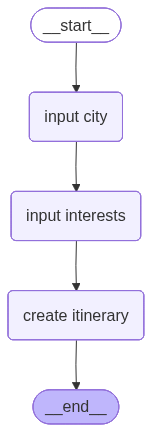

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

Define the function that runs the graph

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content = user_request)],
      "city":"",
      "interests":[],
      "itinerary":""
      }
  for output in app.stream(state):
    pass


In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your input: Goa
Please enter your interests for the trip to : Goa (comma-separated): 
Your input: Beach
Creating an itinerary for Goa based on interests : Beach

Final Itinerary: 
Here's a brief, bulleted itinerary for a day trip to Goa focused on beaches:

* 9:00 AM: Start the day at **Palolem Beach**, known for its picturesque views and tranquil atmosphere.
* 12:00 PM: Head to **Agonda Beach** for lunch and relaxation. This beach is famous for its pristine waters and scenic surroundings.
* 3:00 PM: Visit **Colva Beach**, a popular spot for water sports and activities like parasailing and jet-skiing.
* 6:00 PM: End the day at **Baga Beach**, watching the sunset and enjoying the lively nightlife.

This itinerary provides a mix of relaxation, adventure, and scenic beauty, making for a memorable day trip to Goa's stunning beaches.


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b2ae8c3cc7bca95a67.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
